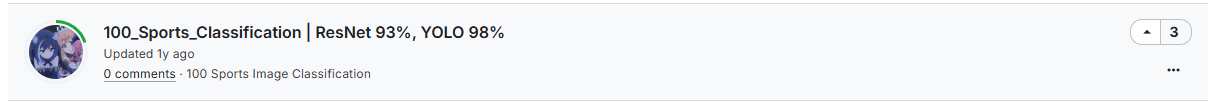

In [1]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from torchinfo import summary

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Raw dataset
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_labels = {}

        # Create a mapping of class labels to integers
        self.class_labels = {}
        class_idx = 0

        # Iterate over sub-directories
        for class_dir in os.listdir(self.root_dir):
            class_dir_path = os.path.join(self.root_dir, class_dir)
            if os.path.isdir(class_dir_path):
                self.class_labels[class_dir] = class_idx
                class_idx += 1

                # Iterate over images in the sub-directory
                for img_filename in os.listdir(class_dir_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(class_dir_path, img_filename)
                        self.images.append(img_path)
                        self.labels.append(self.class_labels[class_dir])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])        
        label = self.labels[idx]
        
        # 檢查有無灰階影像. 如有 -> 增加色彩通道
        if image.mode == "L":
            image = Image.merge("RGB", (image, image, image))
        # 檢查有無transform. 如有 -> transform (image)
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
# pytorch dataloader
def model_dataloder(weights, transform):
    """
    Will return 3 pytorch datalaoder
    """
    weights = weights
    
    data_folder = "D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100"
    data_folder = data_folder.replace("\\", "/")

    train_folder = data_folder + "/train"
    val_folder = data_folder + "/valid"
    test_folder = data_folder + "/test"
    
    # pytorch dataset
    train_dataset = ImageDataset(train_folder, transform = transform)
    val_dataset = ImageDataset(val_folder, transform = transform)
    test_dataset = ImageDataset(test_folder, transform = transform)
    
    # pytorch dataloader
    train_dataloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
    val_dataloader = DataLoader(dataset = val_dataset, batch_size = 32, shuffle = False)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)
    
    return train_dataloader, val_dataloader, test_dataloader

In [4]:
# Train -> train_loss, train_acc
def train (model, dataloader, loss_fn, optimizer, device):
    train_loss, train_acc = 0, 0
    
    model.to(device)
    model.train()
    
    for batch, (x, y) in enumerate (dataloader):
        x, y = x.to(device), y.to(device)
        
        train_pred = model(x)
        
        loss = loss_fn(train_pred, y)
        train_loss = train_loss + loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_pred_label = torch.argmax(torch.softmax(train_pred, dim = 1), dim = 1)
        train_acc = train_acc + (train_pred_label == y).sum().item() / len(train_pred)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [5]:
# Val -> val_loss, val_acc
def val (model, dataloader, loss_fn, device):
    val_loss, val_acc = 0, 0
    
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            
            val_pred = model(x)
            
            loss = loss_fn(val_pred, y)
            val_loss = val_loss + loss.item()
            
            val_pred_label = torch.argmax(torch.softmax(val_pred, dim = 1), dim = 1)
            val_acc = val_acc + (val_pred_label == y).sum().item() / len(val_pred)
        
        val_loss = val_loss / len(dataloader)
        val_acc = val_acc / len(dataloader)
        
        return val_loss, val_acc

In [6]:
# Training loop -> results dictionary
def training_loop(model, train_dataloader, val_dataloader, device, epochs, patience):
    # empty dict for restore results
    results = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    
    # hardcode loss_fn and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
    
    # loop through epochs
    for epoch in range(epochs):
        train_loss, train_acc = train(model = model, 
                                      dataloader = train_dataloader,
                                      loss_fn = loss_fn,
                                      optimizer = optimizer,
                                      device = device)
        
        val_loss, val_acc = val(model = model,
                                dataloader = val_dataloader,
                                loss_fn = loss_fn,
                                device = device)
        
        # print results for each epoch
        print(f"Epoch: {epoch+1}\n"
              f"Train loss: {train_loss:.4f} | Train accuracy: {(train_acc*100):.3f}%\n"
              f"Val loss: {val_loss:.4f} | Val accuracy: {(val_acc*100):.3f}%")
        
        # record results for each epoch
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        
        # calculate average "val_loss" for early_stopping
        mean_val_loss = np.mean(results["val_loss"])
        best_val_loss = float("inf")
        num_no_improvement = 0
        if np.mean(mean_val_loss > best_val_loss):
            best_val_loss = mean_val_loss
        
            model_state_dict = model.state_dict()
            best_model.load_state_dict(model_state_dict)
        else:
            num_no_improvement +=1
    
        if num_no_improvement == patience:
            break
    
    # plt results after early_stopping
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(results["train_loss"], label = "Train loss")
    plt.plot(results["val_loss"], label = "Val loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(results["train_acc"], label = "Train accuracy")
    plt.plot(results["val_acc"], label = "Val accuracy")
    plt.legend()
    
    return results

In [7]:
resnet_weight = torchvision.models.ResNet50_Weights.DEFAULT

resnet_model = torchvision.models.resnet50(weights = resnet_weight)

for param in resnet_model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Leaper/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [06:30<00:00, 262kB/s]


In [8]:
# Custom output layer
# resnet_model.fc

custom_fc = nn.Sequential(
    nn.ReLU(),
    nn.Dropout(p = 0.5),
    nn.Linear(1000, 100))

resnet_model.fc = nn.Sequential(
    resnet_model.fc,
    custom_fc
)

In [9]:
# Check model info
summary(resnet_model, input_size = (1, 3, 244, 244), col_names = ["output_size", "num_params", "trainable"], col_width = 15)

Layer (type:depth-idx)                   Output Shape    Param #         Trainable
ResNet                                   [1, 100]        --              Partial
├─Conv2d: 1-1                            [1, 64, 122, 122] (9,408)         False
├─BatchNorm2d: 1-2                       [1, 64, 122, 122] (128)           False
├─ReLU: 1-3                              [1, 64, 122, 122] --              --
├─MaxPool2d: 1-4                         [1, 64, 61, 61] --              --
├─Sequential: 1-5                        [1, 256, 61, 61] --              False
│    └─Bottleneck: 2-1                   [1, 256, 61, 61] --              False
│    │    └─Conv2d: 3-1                  [1, 64, 61, 61] (4,096)         False
│    │    └─BatchNorm2d: 3-2             [1, 64, 61, 61] (128)           False
│    │    └─ReLU: 3-3                    [1, 64, 61, 61] --              --
│    │    └─Conv2d: 3-4                  [1, 64, 61, 61] (36,864)        False
│    │    └─BatchNorm2d: 3-5             [1, 64

In [10]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
# hardcode :
# loss_fn -> CrossEntropyLoss
# optimizer -> Adam(lr = 0.0005)

In [11]:
# Data augmentation
# resnet_weight.transforms()
resnet_transform = transforms.Compose([
    transforms.Resize(size = 232),
    transforms.ColorJitter(brightness = (0.8, 1.2)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 15),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

resnet_train_dataloader, resnet_val_dataloader, resnet_test_dataloader = model_dataloder(weights = resnet_weight, 
                                                                                         transform = resnet_transform)

Epoch: 1
Train loss: 3.0797 | Train accuracy: 41.718%
Val loss: 1.9709 | Val accuracy: 71.367%
Epoch: 2
Train loss: 1.8022 | Train accuracy: 67.084%
Val loss: 1.2852 | Val accuracy: 78.320%
Epoch: 3
Train loss: 1.3866 | Train accuracy: 72.413%
Val loss: 0.9539 | Val accuracy: 82.109%
Epoch: 4
Train loss: 1.1824 | Train accuracy: 74.584%
Val loss: 0.8174 | Val accuracy: 82.734%
Epoch: 5
Train loss: 1.0448 | Train accuracy: 76.459%
Val loss: 0.7503 | Val accuracy: 85.898%
Epoch: 6
Train loss: 0.9632 | Train accuracy: 78.249%
Val loss: 0.6622 | Val accuracy: 84.883%
Epoch: 7
Train loss: 0.8901 | Train accuracy: 79.102%
Val loss: 0.6121 | Val accuracy: 86.484%
Epoch: 8
Train loss: 0.8376 | Train accuracy: 80.041%
Val loss: 0.5670 | Val accuracy: 87.227%
Epoch: 9
Train loss: 0.8033 | Train accuracy: 80.191%
Val loss: 0.5397 | Val accuracy: 87.070%
Epoch: 10
Train loss: 0.7655 | Train accuracy: 81.069%
Val loss: 0.5550 | Val accuracy: 86.289%
Epoch: 11
Train loss: 0.7449 | Train accuracy: 81

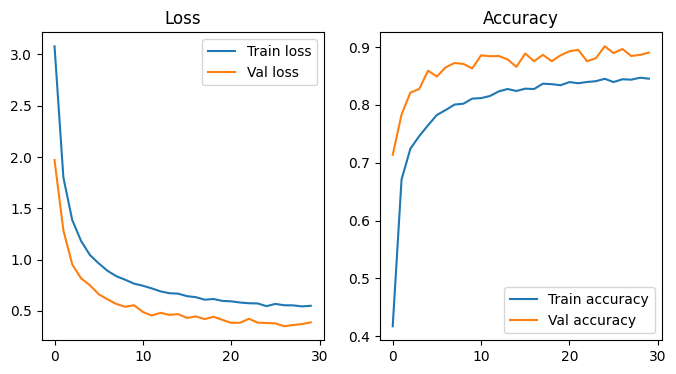

In [12]:
# Actual training ResNet model
resnet_results = training_loop(model = resnet_model,
                               train_dataloader = resnet_train_dataloader,
                               val_dataloader = resnet_val_dataloader,
                               device = device,
                               epochs = 30,
                               patience = 5
                              )

In [13]:
# empty list store labels
predict_label_list = []
actual_label_list = []

# eval mode
resnet_model.eval()

for images, labels in resnet_test_dataloader: 
    
    for label in labels:
        label = label.item()
        actual_label_list.append(label)
    
    for image in images:
        with torch.inference_mode():
            image = image.to(device)
            # add batch_size and device
            image = image.unsqueeze(dim = 0)
            # logits
            logits = resnet_model(image)
            # lables
            label = torch.argmax(logits).item()
            predict_label_list.append(label)

In [14]:
accuracy = accuracy_score(actual_label_list, predict_label_list)

print(f"resnet_model's accuracy: {accuracy*100}%")

resnet_model's accuracy: 91.0%


In [15]:
# get class names
class_names = []

data_folder_path = "D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100/test"
data_folder_path = data_folder_path.replace("\\", "/")

for name in sorted(os.listdir(data_folder_path)):
    class_names.append(name)

In [16]:
clf_report = classification_report(actual_label_list, 
                                   predict_label_list, 
                                   target_names = class_names
                                  )
print(clf_report)

                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       0.83      1.00      0.91         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.83      1.00      0.91         5
        barell racing       1.00      0.80      0.89         5
             baseball       1.00      0.40      0.57         5
           basketball       0.75      0.60      0.67         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       1.00      0.80      0.89         5
            billiards       1.00      1.00      1.00         5
                  bmx       0.83      1.00      0.91         5
              bobsled       1.00      1.00      1.00         5
              bowling       1.00      1.00      1.00  

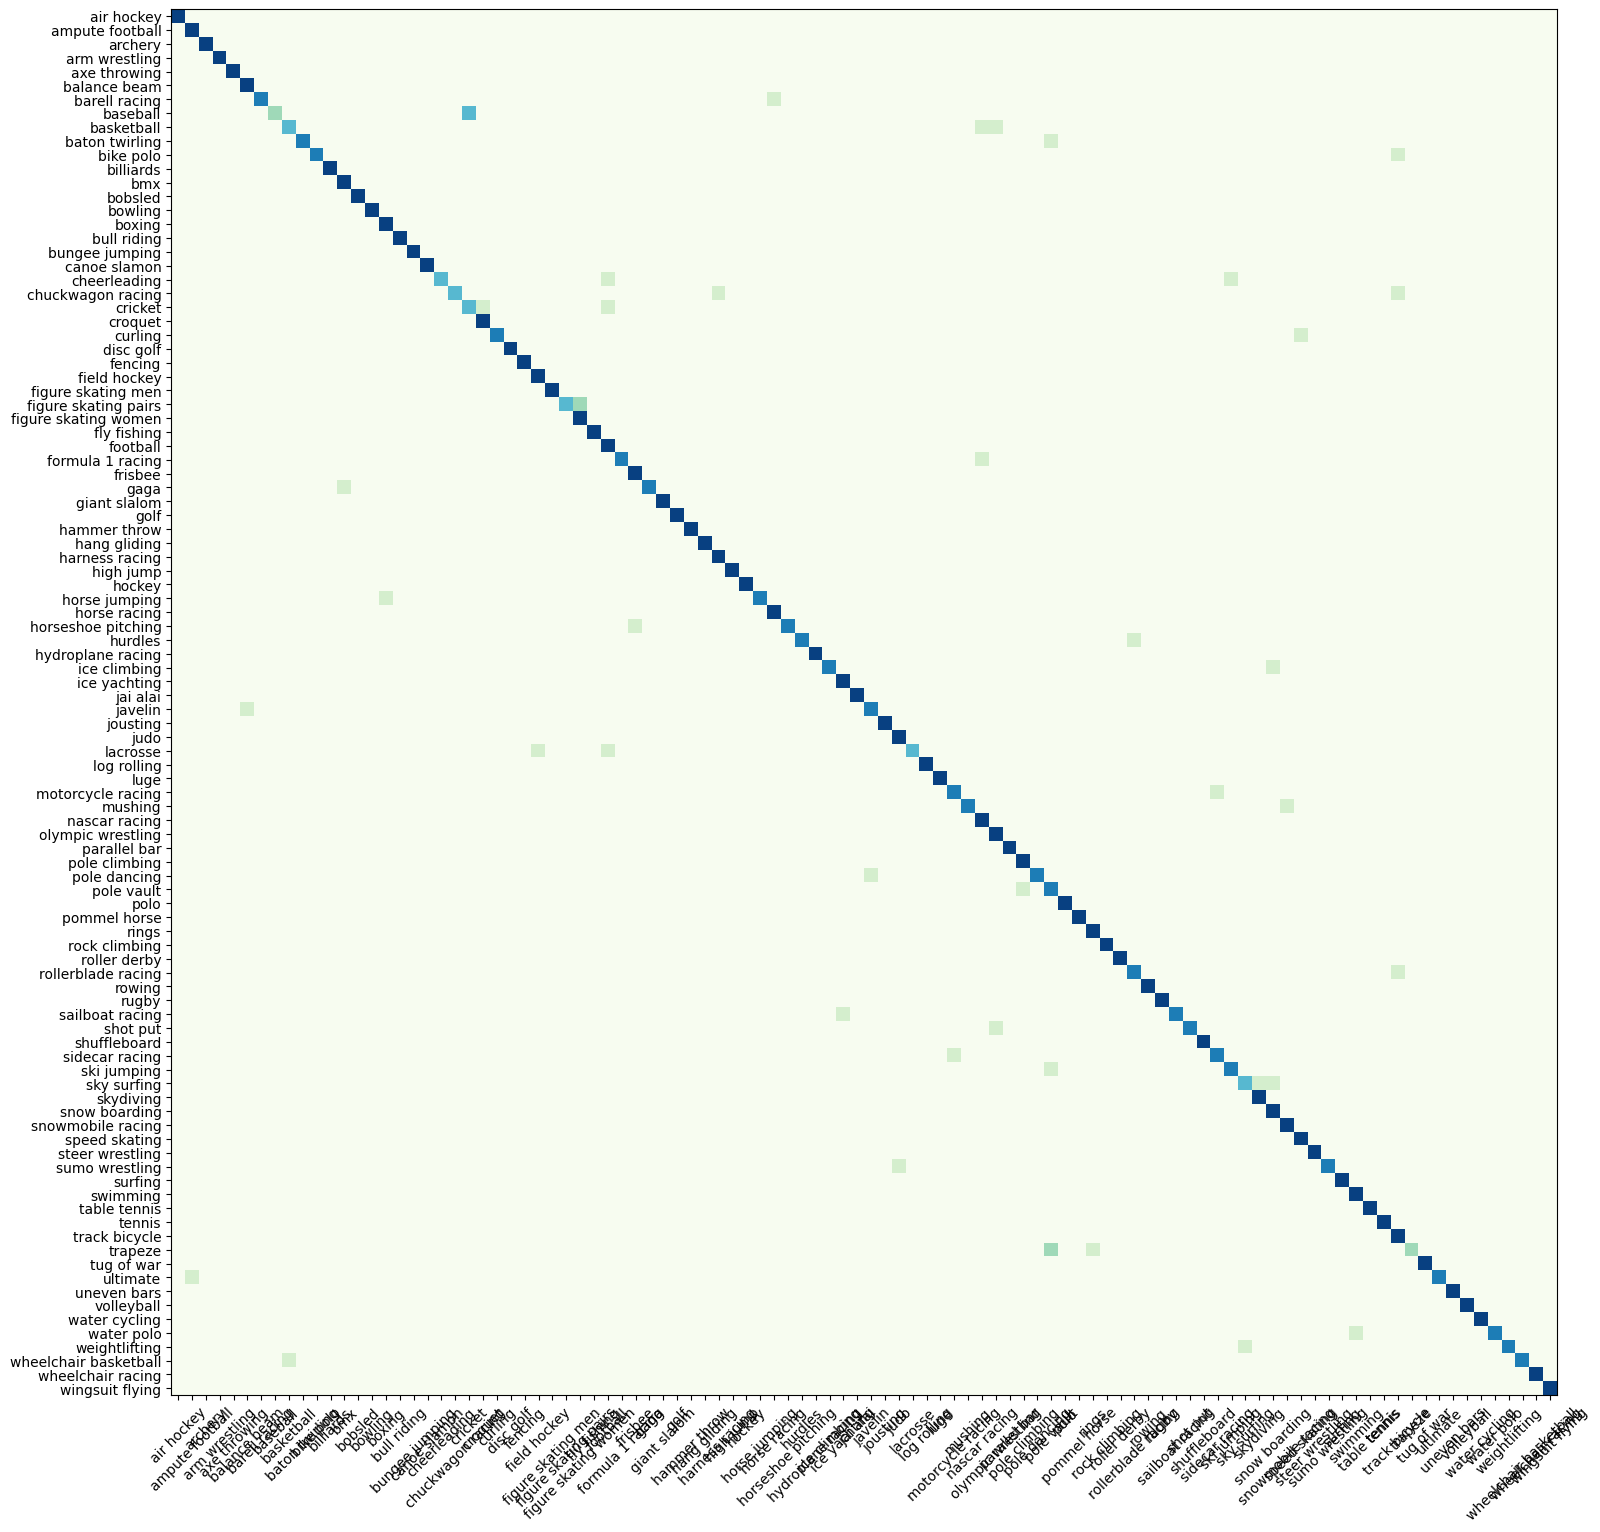

In [17]:
matrix = confusion_matrix(actual_label_list, 
                          predict_label_list
                         )

plt.figure(figsize = (18, 18))
plt.imshow(matrix, interpolation= "nearest", cmap = "GnBu")

ticks = range(len(class_names))
plt.xticks(ticks, class_names, rotation= 45)
plt.yticks(ticks, class_names)
plt.show()

YOLO


In [18]:
# !pip install ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Leaper\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
# Train YOLO model
root_dir = "D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100"
root_dir = root_dir.replace("\\", "/")

yolo_model = YOLO("./yolov8n-cls.pt")

yolo_results = yolo_model.train(data = root_dir, 
                                epochs = 30,
                                imgsz = 256 
                                # similar with ResNet model -> but 256 (YOLO need multiple 32)
                               )

Ultralytics 8.3.62  Python-3.9.0 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: task=classify, mode=train, model=./yolov8n-cls.pt, data=D:/code_study/ML_CODE/dataSets/Sports_Image_Classification_100, epochs=30, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

train: Scanning D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100\train... 13492 images, 0 corrupt: 100%|██████████| 13492/13492 [00:01<00:00, 10994.14it/s]


train: New cache created: D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100\train.cache


val: Scanning D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100\test... 500 images, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 6864.50it/s]

val: New cache created: D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100\test.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs\classify\train
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 61.06it/s]

                   all      0.766      0.946



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 74.97it/s]

                   all       0.87       0.99



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 74.47it/s]

                   all      0.916      0.996



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 72.97it/s]

                   all       0.94      0.996



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 64.38it/s]

                   all      0.938      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 73.38it/s]

                   all      0.948      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 27.13it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 38.98it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:00<00:00, 34.85it/s]

                   all      0.946      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      10/30     0.558G     0.3127          4        256: 100%|██████████| 844/844 [00:34<00:00, 24.52it/s]
        

                   all      0.962      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      11/30     0.558G     0.2821          4        256: 100%|██████████| 844/844 [00:34<00:00, 24.25it/s]
        

                   all      0.956          1

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      12/30     0.558G     0.2591          4        256: 100%|██████████| 844/844 [00:35<00:00, 24.02it/s]
        

                   all      0.968          1

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      13/30     0.558G     0.2506          4        256: 100%|██████████| 844/844 [00:34<00:00, 24.47it/s]
        

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      14/30     0.558G     0.2259          4        256: 100%|██████████| 844/844 [00:34<00:00, 24.18it/s]
        

                   all      0.962      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      15/30     0.558G     0.2104          4        256: 100%|██████████| 844/844 [00:35<00:00, 24.10it/s]
        

                   all      0.964      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      16/30     0.558G     0.2046          4        256: 100%|██████████| 844/844 [00:35<00:00, 23.75it/s]
        

                   all      0.972      0.996



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      17/30     0.558G     0.1883          4        256: 100%|██████████| 844/844 [00:35<00:00, 23.82it/s]
        

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      18/30     0.558G     0.1712          4        256: 100%|██████████| 844/844 [00:35<00:00, 24.01it/s]
        

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      19/30     0.558G      0.162          4        256: 100%|██████████| 844/844 [00:23<00:00, 35.82it/s]
        

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      20/30     0.558G     0.1577          4        256: 100%|██████████| 844/844 [00:22<00:00, 37.34it/s]
        

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      21/30     0.621G     0.1481          4        256: 100%|██████████| 844/844 [00:27<00:00, 30.18it/s]
        

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      22/30     0.591G     0.1404          4        256: 100%|██████████| 844/844 [00:22<00:00, 37.04it/s]
        

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      23/30      0.57G     0.1365          4        256: 100%|██████████| 844/844 [00:23<00:00, 36.18it/s]
        

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      24/30     0.558G     0.1277          4        256: 100%|██████████| 844/844 [00:32<00:00, 26.07it/s]
        

                   all      0.968      0.998



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      25/30     0.558G     0.1223          4        256: 100%|██████████| 844/844 [00:26<00:00, 31.53it/s]
        

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      26/30     0.558G     0.1213          4        256: 100%|██████████| 844/844 [00:21<00:00, 38.68it/s]
        

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      27/30     0.558G     0.1067          4        256: 100%|██████████| 844/844 [00:25<00:00, 33.54it/s]
        

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      28/30     0.558G     0.1118          4        256: 100%|██████████| 844/844 [00:22<00:00, 38.05it/s]
        

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      29/30     0.558G     0.1082          4        256: 100%|██████████| 844/844 [00:22<00:00, 38.17it/s]
        

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/844 [00:00<?, ?it/s]c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      30/30     0.558G     0.1045          4        256: 100%|██████████| 844/844 [00:22<00:00, 37.90it/s]
        

                   all       0.97          1



30 epochs completed in 0.243 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.2MB

Validating runs\classify\train\weights\best.pt...
Ultralytics 8.3.62  Python-3.9.0 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,562,980 parameters, 0 gradients, 3.4 GFLOPs
WARNING  Dataset 'split=val' not found, using 'split=test' instead.
train: D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100\train... found 13492 images in 100 classes  
val: None...
test: D:\code_study\ML_CODE\dataSets\Sports_Image_Classification_100\test... found 500 images in 100 classes  


c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\ultralytics\utils\torch_utils.py:262: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\Context.cpp:208.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\ultralytics\utils\torch_utils.py:267: UserWarning: Deterministic behavior was enabled with either `torch.use_deter

                   all      0.978          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train


In [26]:
yolo_result_csv = "./runs/classify/train/results.csv"

pd.read_csv(yolo_result_csv).tail(5)

,epoch,time,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
25,26,780.512,0.12126,0.970,1.0,0.06547,0.000125,0.000125,0.000125
26,27,806.131,0.10666,0.972,1.0,0.07109,0.000101,0.000101,0.000101
27,28,828.769,0.11176,0.972,1.0,0.07717,0.000078,0.000078,0.000078
28,29,851.308,0.10821,0.972,1.0,0.06915,0.000054,0.000054,0.000054
29,30,873.994,0.10450,0.970,1.0,0.07549,0.000031,0.000031,0.000031


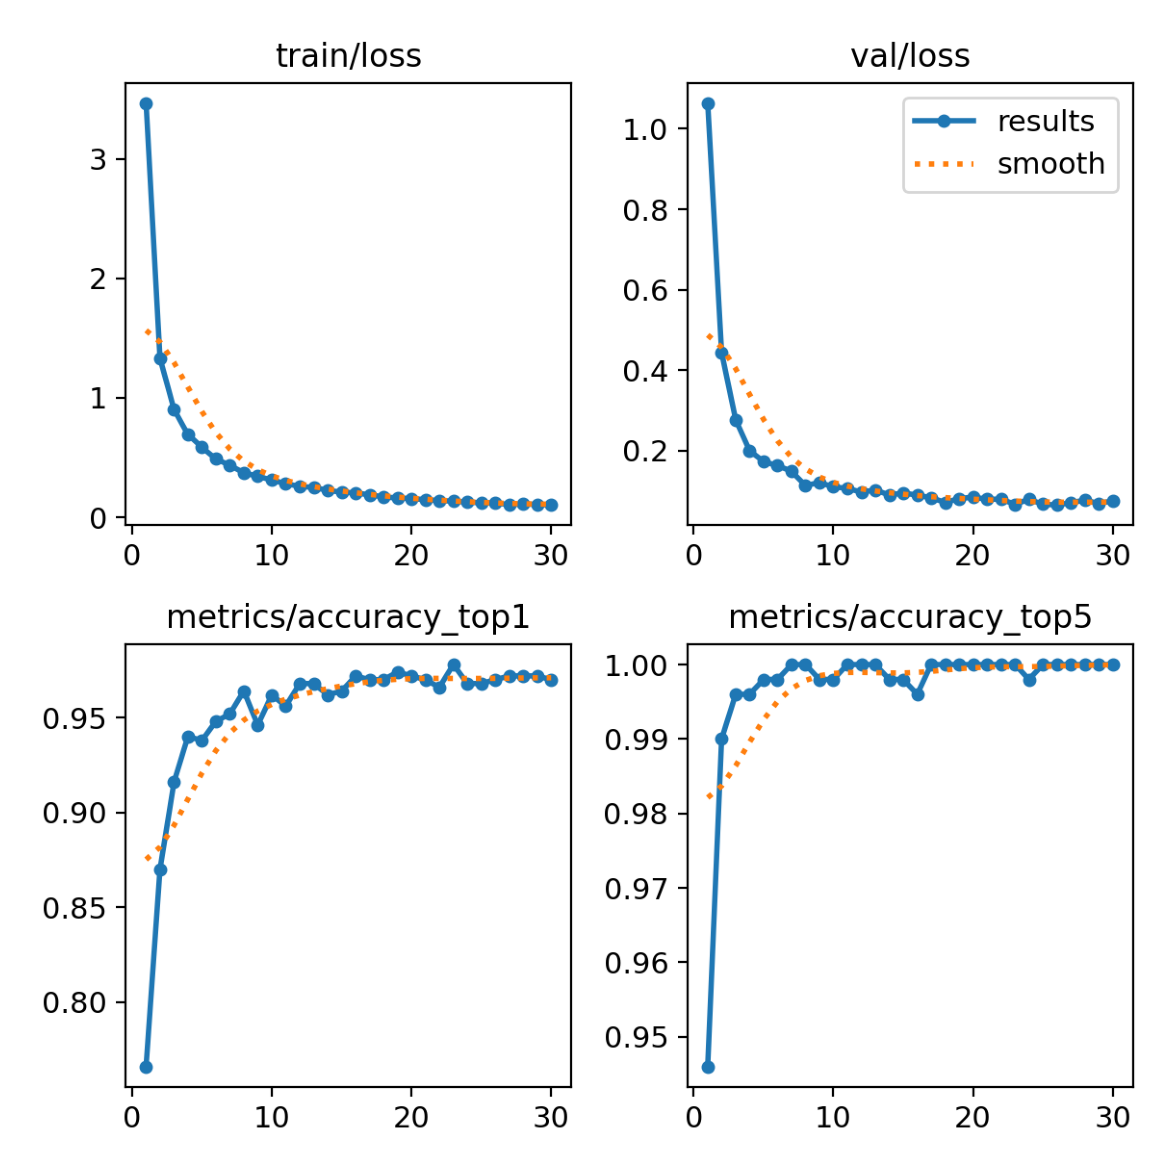

In [27]:
yolo_result_img = "./runs/classify/train/results.png"
yolo_result_img = Image.open(yolo_result_img)

plt.figure(figsize = (15, 15))
plt.imshow(yolo_result_img)
plt.axis("off");

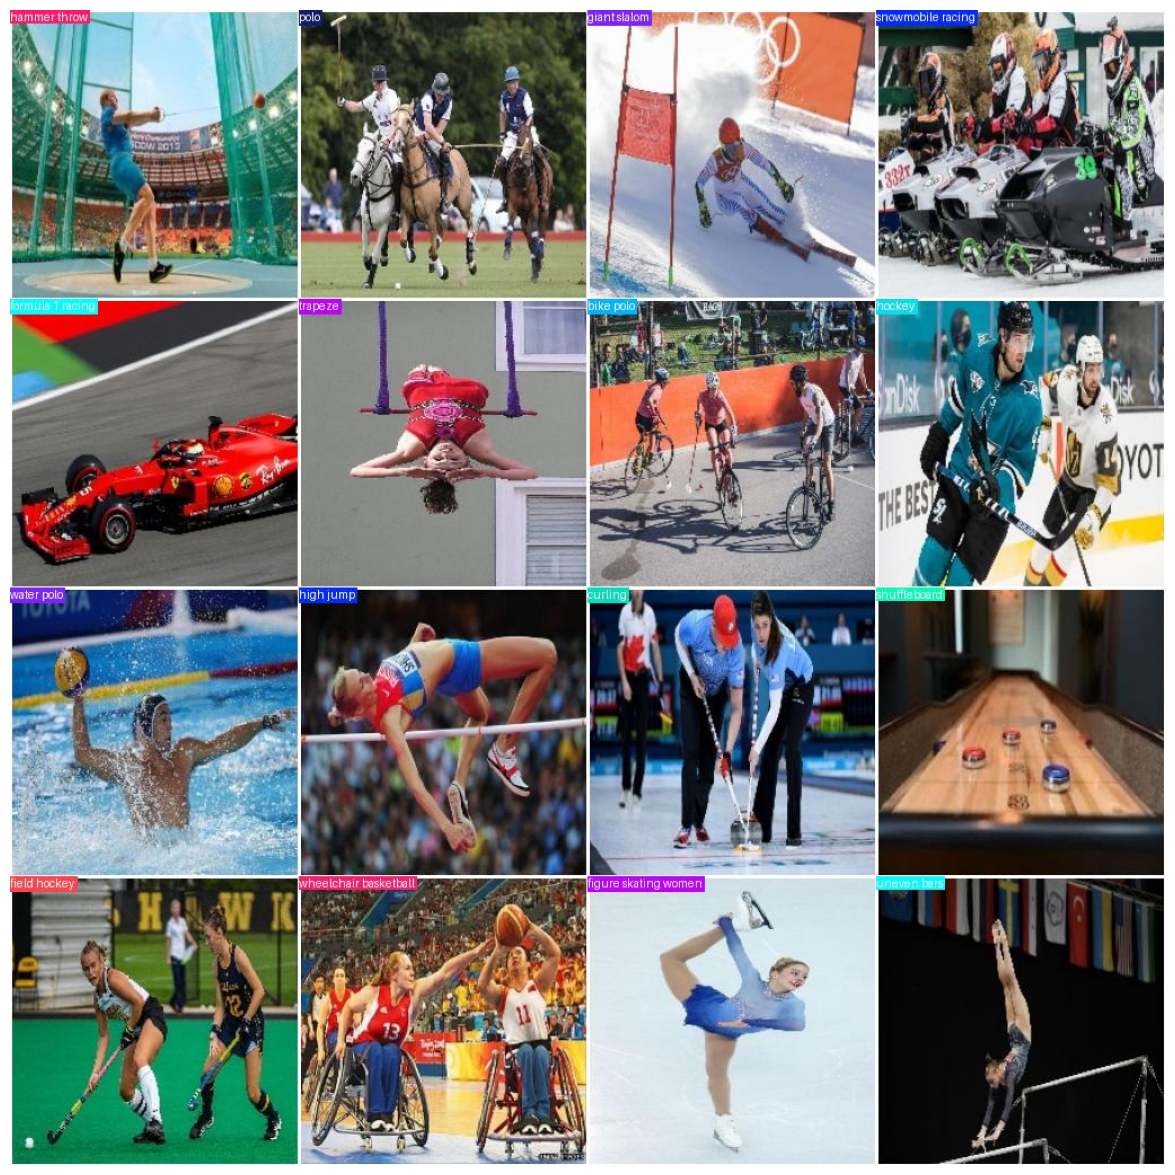

In [28]:
yolo_pred_img = "./runs/classify/train/val_batch1_pred.jpg"
yolo_pred_img = Image.open(yolo_pred_img)

plt.figure(figsize = (15, 15))
plt.imshow(yolo_pred_img)
plt.axis("off");